## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Importing the libraries

In [1]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Decrease the batch size 
# Decrease the no. of images in img_idx 
# Decrease the image size 
# Decrease the no of epochs 
# Simplifying the architechture (Reducing the layers/neurons)

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

GPU device not found


In [4]:
## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
train_doc = np.random.permutation(open(r'D:\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'D:\Project_data\val.csv').readlines())
batch_size = 30

In [5]:
def cropResize(image, y, z):
    h, w = image.shape

    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [6]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [7]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [8]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [9]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
n_frames= 16
img_tensor = getImgTensor(n_frames)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27, 29]), 100, 100, 3]


In [10]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [11]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

In [12]:
train_path = r'D:\Project_data\train'
val_path = r'D:\Project_data\val'

## Validating Generator 

In [13]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  D:\Project_data\train ; batch size = 30
(30, 16, 100, 100, 3)
Source path =  D:\Project_data\val ; batch size = 30
(30, 16, 100, 100, 3)


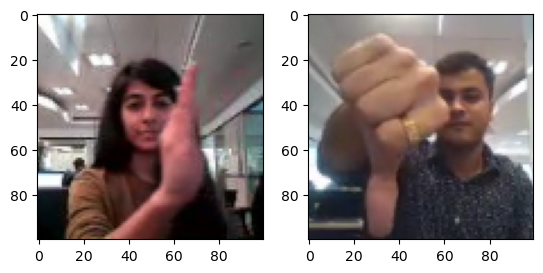

In [14]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[16,10,:,:,:])
ax[1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

In [15]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

In [17]:

def train_model(model, train_generator, val_generator, batch_size, num_epochs):
    
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    model_name = 'D:/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    
    earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)

    callbacks_list = [checkpoint, LR, earlystop]

    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model_history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None, initial_epoch=0)
    return model_history

### Model 1 - CONV 3D

In [18]:
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),


        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),


        Dropout(0.25),
        
        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),

        
        Conv3D(128, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),

        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),


        Dense(64, activation='relu'),
        BatchNormalization(),

        Dense(5, activation='softmax')
    ])
    
    return model





In [19]:
batch_size=30
no_epochs = 30
n_frames = 30
img_tensor = getImgTensor(n_frames)
model1 = defineModel(img_tensor)
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 26, 96, 96, 16)      │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 13, 48, 48, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 11, 46, 46, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 11, 23, 23, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 23, 23, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 9, 21, 21, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 9, 11, 11, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 7, 9, 9, 128)        │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 7, 5, 5, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 22400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,867,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,173,221 (12.10 MB)

 Trainable params: 3,172,837 (12.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
model1_hist = train_model(model1, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 30
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.3157 - loss: 1.7698Source path =  D:\Project_data\val ; batch size = 30

Epoch 1: val_loss improved from inf to 14.24438, saving model to D:/model_init_2024-04-2816_19_56.916283/model-00001-1.59012-0.35143-14.24438-0.17000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - categorical_accuracy: 0.3172 - loss: 1.7623 - val_categorical_accuracy: 0.1700 - val_loss: 14.2444 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - categorical_accuracy: 0.3765 - loss: 1.4923
Epoch 2: val_loss improved from 14.24438 to 8.08199, saving model to D:/model_init_2024-04-2816_19_56.916283/model-00002-1.56641-0.36232-8.08199-0.25000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 792ms/step - categorical_accuracy: 0.3759 - loss: 1.4954 - val_categorical_accuracy: 0.2500 - val_loss: 8.0820 - learning_rate: 0.00

Epoch 20/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - categorical_accuracy: 0.2829 - loss: 1.6692
Epoch 20: val_loss did not improve from 1.54981
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 700ms/step - categorical_accuracy: 0.2832 - loss: 1.6690 - val_categorical_accuracy: 0.3250 - val_loss: 1.6247 - learning_rate: 2.0000e-04
Epoch 21/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - categorical_accuracy: 0.2655 - loss: 1.5763
Epoch 21: val_loss did not improve from 1.54981
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 644ms/step - categorical_accuracy: 0.2671 - loss: 1.5776 - val_categorical_accuracy: 0.3750 - val_loss: 1.5750 - learning_rate: 2.0000e-04
Epoch 22/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - categorical_accuracy: 0.2171 - loss: 1.6128
Epoch 22: val_loss improved from 1.54981 to 1.45918, saving model to D:/model_init_2024-04-2816_19_56.916283/model-00022-1.57907-0.24638-1.45918-0.45000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 701ms/step - categorical_accuracy: 0.2183 - loss: 1.6114 - val_categorical_ac

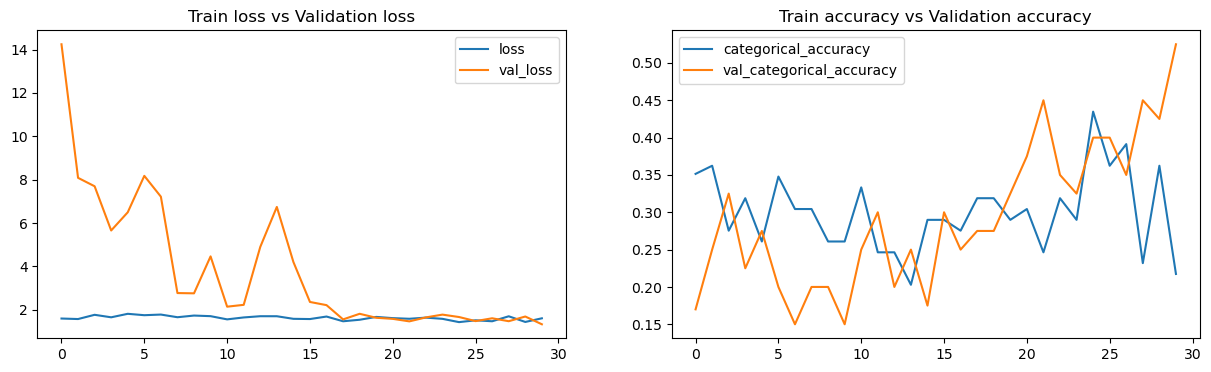

Max. Training Accuracy 0.43478259444236755
Max. Validaiton Accuracy 0.5249999761581421


In [21]:
plotModelHistory(model1_hist)

### Model 2- CONV3D

In [22]:
def defineModel2(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),


        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),

        
        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),


        
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),


        Dense(64, activation='relu'),
        BatchNormalization(),

        Dense(5, activation='softmax')
    ])
    
    return model

img_tensor = getImgTensor(n_frames)
model2 = defineModel2(img_tensor)
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_4 (Conv3D)                    │ (None, 26, 96, 96, 16)      │           6,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 13, 48, 48, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_5 (Conv3D)                    │ (None, 11, 46, 46, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 11, 23, 23, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_6 (Conv3D)                    │ (None, 9, 21, 21, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 9, 11, 11, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 69696)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       8,921,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,005,797 (34.35 MB)

 Trainable params: 9,005,413 (34.35 MB)

 Non-trainable params: 384 (1.50 KB)

In [23]:
batch_size=20
no_epochs = 30
n_frames = 20

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
model2_hist = train_model(model2, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 20
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.3772 - loss: 1.7132Source path =  D:\Project_data\val ; batch size = 20

Epoch 1: val_loss improved from inf to 12.32557, saving model to D:/model_init_2024-04-2816_33_00.440206/model-00001-1.51032-0.41931-12.32557-0.28000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - categorical_accuracy: 0.3784 - loss: 1.7074 - val_categorical_accuracy: 0.2800 - val_loss: 12.3256 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - categorical_accuracy: 0.2747 - loss: 1.6749
Epoch 2: val_loss did not improve from 12.32557
34/34 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - categorical_accuracy: 0.2744 - loss: 1.6754 - val_categorical_accuracy: 0.2500 - val_loss: 15.7103 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - categorical_accuracy: 0.3432 - loss: 1.6196
Epoch 3: val

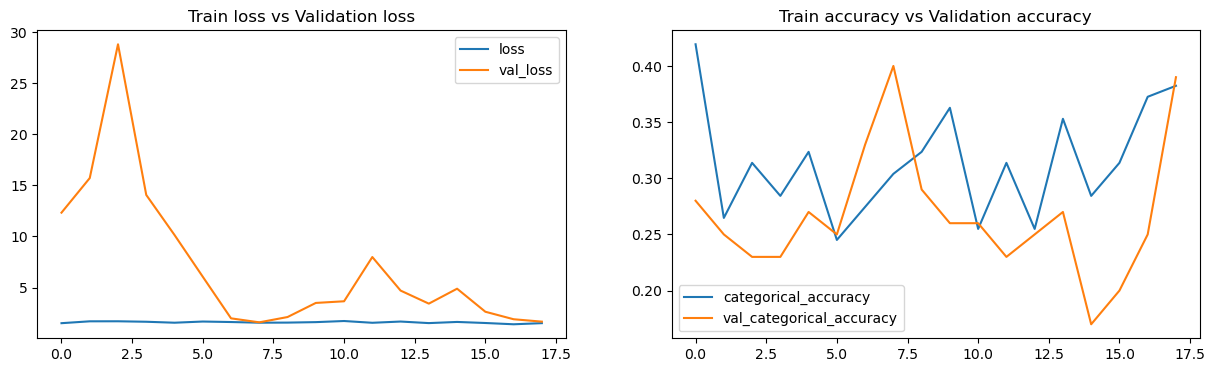

Max. Training Accuracy 0.4193061888217926
Max. Validaiton Accuracy 0.4000000059604645


In [24]:
plotModelHistory(model2_hist)

### Model 3 - CONV3D

In [26]:
def defineModel3(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(3), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),
        
        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),
        
        Flatten(),
        Dense(128, activation='relu'),

        Dense(64, activation='relu'),


        Dense(5, activation='softmax')
    ])
    
    return model

img_tensor = getImgTensor(n_frames)
model3 = defineModel3(img_tensor)
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)                   │ (None, 18, 98, 98, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 9, 49, 49, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 9, 49, 49, 16)       │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_11 (Conv3D)                   │ (None, 7, 47, 47, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 7, 24, 24, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 24, 24, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_12 (Conv3D)                   │ (None, 5, 22, 22, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 5, 11, 11, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 5, 11, 11, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 38720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       4,956,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,035,845 (19.21 MB)

 Trainable params: 5,035,621 (19.21 MB)

 Non-trainable params: 224 (896.00 B)

In [27]:
batch_size=30
no_epochs = 30
n_frames = 20

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)
model3_hist = train_model(model3, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 30
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4515 - loss: 2.9574Source path =  D:\Project_data\val ; batch size = 30

Epoch 1: val_loss improved from inf to 2.00046, saving model to D:/model_init_2024-04-2816_48_40.298419/model-00001-2.18443-0.52790-2.00046-0.15000.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - categorical_accuracy: 0.4547 - loss: 2.9252 - val_categorical_accuracy: 0.1500 - val_loss: 2.0005 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - categorical_accuracy: 0.4985 - loss: 2.9397
Epoch 2: val_loss did not improve from 2.00046
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - categorical_accuracy: 0.4994 - loss: 2.9822 - val_categorical_accuracy: 0.1750 - val_loss: 12.4825 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - categorical_accuracy: 0.3903 - loss: 5.4847
Epoch 3: val_l

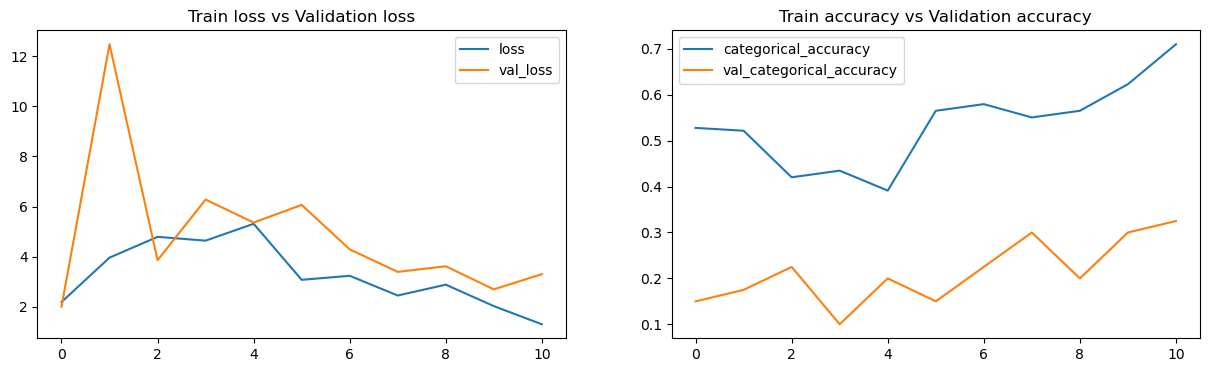

Max. Training Accuracy 0.7101449370384216
Max. Validaiton Accuracy 0.32499998807907104


In [28]:
plotModelHistory(model3_hist)

### Model 4 - CNN RNN Model LSTM

In [35]:
n_frames = 20
img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")

model6.summary()

Model: "conv_2d_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_32                  │ (None, 20, 100, 100, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 20, 50, 50, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_37                  │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_38                  │ (None, 20, 25, 25, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_39                  │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_40                  │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_41                  │ (None, 20, 12, 12, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_42                  │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_43                  │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_44                  │ (None, 20, 6, 6, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_45                  │ (None, 20, 6, 6, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,084,133 (11.77 MB)

 Trainable params: 3,083,141 (11.76 MB)

 Non-trainable params: 992 (3.88 KB)

In [30]:

no_epochs = 30
batch_size = 20

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

cnnlstm = train_model(model6, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 20
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - categorical_accuracy: 0.3387 - loss: 1.5040 Source path =  D:\Project_data\val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.13021, saving model to D:/model_init_2024-04-2816_56_39.656333/model-00001-1.26419-0.46305-1.13021-0.57000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1051s 29s/step - categorical_accuracy: 0.3422 - loss: 1.4972 - val_categorical_accuracy: 0.5700 - val_loss: 1.1302 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4592 - loss: 1.3495
Epoch 2: val_loss did not improve from 1.13021
34/34 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - categorical_accuracy: 0.4575 - loss: 1.3528 - val_categorical_accuracy: 0.4000 - val_loss: 1.4916 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4220 - loss: 1.5376
Epoch 3: val_loss i

Epoch 19/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.7632 - loss: 0.7442
Epoch 19: val_loss improved from 0.78981 to 0.76835, saving model to D:/model_init_2024-04-2816_56_39.656333/model-00019-0.85382-0.70588-0.76835-0.77000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - categorical_accuracy: 0.7616 - loss: 0.7473 - val_categorical_accuracy: 0.7700 - val_loss: 0.7683 - learning_rate: 2.0000e-04
Epoch 20/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5837 - loss: 1.2029
Epoch 20: val_loss did not improve from 0.76835
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - categorical_accuracy: 0.5843 - loss: 1.1980 - val_categorical_accuracy: 0.7400 - val_loss: 0.7746 - learning_rate: 2.0000e-04
Epoch 21/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6066 - loss: 1.0530
Epoch 21: val_loss improved from 0.76835 to 0.76094, saving model to D:/model_init_2024-04-2816_56_39.656333/model-00021-0.77638-0.74510-0.76094-0.77000.keras
34/34 ━━━━━━

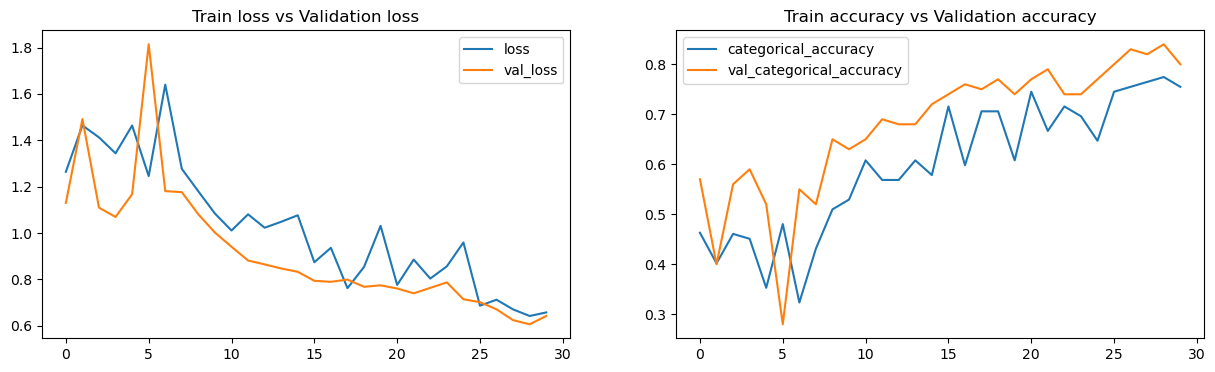

Max. Training Accuracy 0.7745097875595093
Max. Validaiton Accuracy 0.8399999737739563


In [31]:
plotModelHistory(cnnlstm)

### Model 5 - CNN RNN Model GRU

In [32]:
n_frames = 20
img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

modelGRU = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    GRU(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_gru")

modelGRU.summary()

Model: "conv_2d_gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_16                  │ (None, 20, 100, 100, 16)    │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 20, 100, 100, 16)    │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 20, 50, 50, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 20, 50, 50, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 20, 50, 50, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 20, 25, 25, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 20, 25, 25, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 20, 25, 25, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 20, 12, 12, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 20, 12, 12, 128)     │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 20, 12, 12, 128)     │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 20, 6, 6, 128)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 20, 6, 6, 256)       │         295,168 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 20, 6, 6, 256)       │           1,024 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,429,285 (9.27 MB)

 Trainable params: 2,428,293 (9.26 MB)

 Non-trainable params: 992 (3.88 KB)

In [33]:

no_epochs = 25
batch_size = 20

train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

cnnGRU = train_model(modelGRU, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 20
Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.3820 - loss: 1.5591 Source path =  D:\Project_data\val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.05137, saving model to D:/model_init_2024-04-2817_36_49.226098/model-00001-1.30845-0.47210-1.05137-0.62000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 398s 10s/step - categorical_accuracy: 0.3846 - loss: 1.5519 - val_categorical_accuracy: 0.6200 - val_loss: 1.0514 - learning_rate: 0.0010
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.5505 - loss: 1.1157
Epoch 2: val_loss did not improve from 1.05137
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - categorical_accuracy: 0.5477 - loss: 1.1208 - val_categorical_accuracy: 0.5800 - val_loss: 1.0880 - learning_rate: 0.0010
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.4238 - loss: 1.4312
Epoch 3: val_loss did

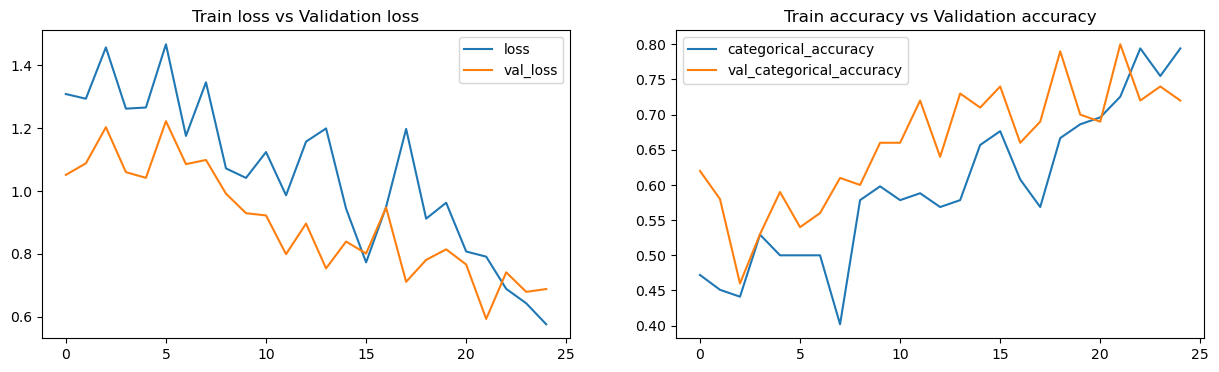

Max. Training Accuracy 0.7941176295280457
Max. Validaiton Accuracy 0.800000011920929


In [34]:
plotModelHistory(cnnGRU)

### Model 6 - CNN RNN Transfer Learning 

In [36]:
from keras.applications import mobilenet

mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 20
batch_size = 10

img_tensor = getImgTensor(n_frames)
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_GRU")

for layer in model7.layers:
    layer.trainable = True

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(GRU(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

print(model7.summary())


Model: "mobilenet_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_48                  │ ?                           │       3,228,864 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_49                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_50                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_51                  │ ?                           │     0 (unbuilt) │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

None


In [37]:
n_frames = 20
no_epochs = 20
batch_size = 10

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

cnngru_transfer = train_model(model7, train_generator, val_generator, batch_size, no_epochs)

# training sequences = 663
# validation sequences = 100
Source path =  D:\Project_data\train ; batch size = 10
Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.5563 - loss: 1.1163Source path =  D:\Project_data\val ; batch size = 10

Epoch 1: val_loss improved from inf to 0.51898, saving model to D:/model_init_2024-04-2818_05_03.147579/model-00001-0.87136-0.67421-0.51898-0.84000.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - categorical_accuracy: 0.5580 - loss: 1.1127 - val_categorical_accuracy: 0.8400 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6223 - loss: 1.0858
Epoch 2: val_loss did not improve from 0.51898
67/67 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - categorical_accuracy: 0.6223 - loss: 1.0856 - val_categorical_accuracy: 0.7000 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.7160 - loss: 0.9380
Epoch 3: val_loss did n

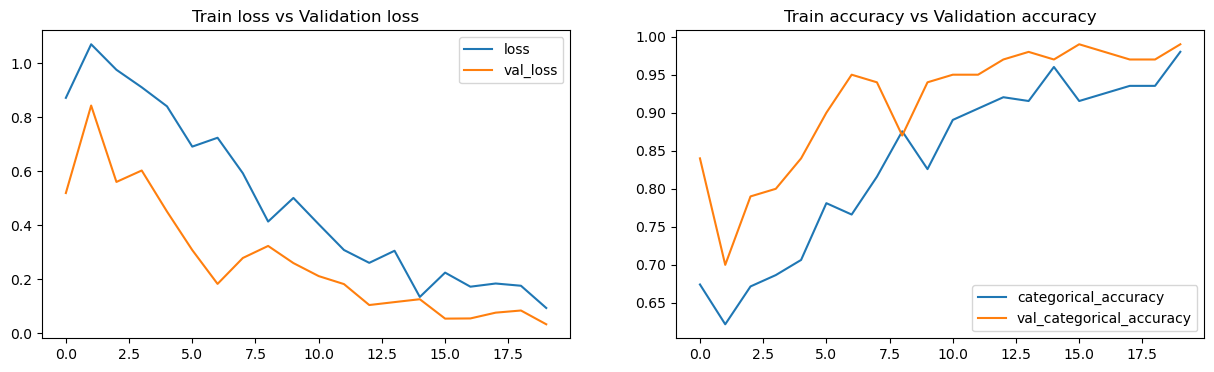

Max. Training Accuracy 0.9800994992256165
Max. Validaiton Accuracy 0.9900000095367432


In [43]:
plotModelHistory(cnngru_transfer)

### Loading model and testing

In [40]:
import time
from keras.models import load_model
model = load_model('D:\model_init_2024-04-2818_05_03.147579\model-00020-0.09356-0.98010-0.03321-0.99000.keras')
img_tensor = getImgTensor(20)
val_generator = generator(val_path, val_doc, 10, img_tensor)
batch_data, batch_label = next(val_generator)
print(batch_data)



Source path =  D:\Project_data\val ; batch size = 10
[[[[[0.55529416 0.45921567 0.38588235]
    [0.55082357 0.45792156 0.38105881]
    [0.53725493 0.45352942 0.36862746]
    ...
    [0.51882356 0.44392157 0.34999999]
    [0.52603924 0.4570196  0.37231374]
    [0.52227449 0.4721961  0.39019608]]

   [[0.48588237 0.41686276 0.36352941]
    [0.48423532 0.4145098  0.35835293]
    [0.48313725 0.41176471 0.34921569]
    ...
    [0.51411766 0.43333334 0.33999997]
    [0.51956862 0.44819608 0.36113724]
    [0.52286273 0.46090195 0.37972549]]

   [[0.43137255 0.39215687 0.36274511]
    [0.43254903 0.39098039 0.36156863]
    [0.43529412 0.3882353  0.35490197]
    ...
    [0.51862746 0.43039215 0.33529413]
    [0.51764709 0.43686274 0.33941177]
    [0.51764709 0.4480392  0.35352942]]

   ...

   [[0.16156863 0.13607843 0.07901961]
    [0.16509803 0.14254901 0.08137255]
    [0.16078432 0.14117648 0.07647059]
    ...
    [0.22450981 0.14509805 0.03235294]
    [0.23549019 0.18117647 0.07215686]
    

In [41]:
print(batch_label)

[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [42]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
[4 1 3 0 2 1 3 1 2 0]
